# RandomForestRegression Year column embedding
    1. Year column embedding code to preserve time series properties.
    2. stock별 시계열패턴을 모델이 학습할수 있도록 작성된 코드.

In [1]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# RandomForestRegressor (multi-output 지원)
model = RandomForestRegressor(
    n_estimators=900,
    max_depth=None,           
    min_samples_split=2,
    min_samples_leaf=1,
    n_jobs=-1,                
    random_state=42,
    oob_score=False,
    verbose=0
)
model

,n_estimators,900
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [2]:
# Set target_columns
target_columns = ['CETR', 'GETR', 'TSTA', 'TSDA']

In [ ]:
# Load CSV file
df = pd.read_csv('../data_result/KoTaP_Dataset.csv')
df.shape

,name,stock,year,KOSPI,fnd_year,fiscal,ind,big4,forn,own,...,GETR5,CETR5,TSTA,TSDA,A_GETR,A_CETR,A_GETR3,A_CETR3,A_GETR5,A_CETR5
0,동화약품,20,2013,1,1897,12,21,1,0.0613,0.3114,...,0.294414,0.266121,-0.071863,-0.088363,-0.236479,0.748503,0.058765,-0.096756,0.034497,-0.019779
1,동화약품,20,2014,1,1897,12,21,1,0.0502,0.3151,...,0.233461,0.418783,-0.001226,-0.014614,-0.150710,0.748503,0.500993,0.733432,-0.026455,0.132883
2,동화약품,20,2015,1,1897,12,21,1,0.0749,0.3235,...,0.231593,0.528209,0.072994,0.056283,-0.171420,-0.024525,-0.195255,0.733432,-0.028324,0.242310
3,동화약품,20,2016,1,1897,12,21,1,0.0746,0.3229,...,0.306044,0.325968,0.106756,0.107570,0.026917,-0.194237,-0.174602,0.327249,0.046128,0.040069
4,동화약품,20,2017,1,1897,12,21,1,0.1186,0.3240,...,0.250474,0.216419,-0.061506,0.008744,0.042469,-0.157749,-0.014648,-0.184860,-0.009442,-0.069481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12648,잉글우드랩,950140,2023,0,2015,12,20,0,0.1248,0.4408,...,0.174191,0.211668,-0.317902,-0.362904,-0.122071,0.080095,-0.064306,0.002523,0.001916,0.012473
12649,잉글우드랩,950140,2024,0,2015,12,20,0,0.1358,0.4408,...,0.114758,0.256242,-0.358287,-0.384294,-0.123269,0.292943,-0.129741,0.004858,-0.091928,0.027420
12650,고스트스튜디오,950190,2022,0,2016,12,58,1,0.1374,0.4427,...,0.176417,0.172354,-0.109588,-0.137899,-0.055951,-0.122758,-0.039628,0.121765,-0.064150,-0.092251
12651,고스트스튜디오,950190,2023,0,2016,12,58,1,0.1445,0.5158,...,0.180101,0.204584,-0.225762,-0.237668,-0.034687,-0.052817,-0.041439,-0.021230,-0.060466,-0.060022


In [4]:
# Categorical 컬럼 설정 (CatBoost/XGBoost와 동일 구조 유지)
categorical_cols = ['name', 'stock', 'KOSPI', 'big4', 'LOSS', 'ind']
for col in categorical_cols:
    df[col] = df[col].astype('category')

print('Categorical dtypes:')
print(df[categorical_cols].dtypes)

Categorical dtypes:
name     category
stock    category
KOSPI    category
big4     category
LOSS     category
ind      category
dtype: object


In [5]:
# 카테고리 최소 인코딩 단계
# 전략:
# 1) high-cardinality 후보(ind, name)는 원본 유지 (추후 필요시 제거)
# 2) 저카디널리티(KOSPI, big4, LOSS)는 one-hot (drop_first) 적용
# 3) stock 고정효과는 통계 파생(평균, count 등)으로 후속 셀에서 제공 예정
# 4) potential removal candidates (후속 중요도 낮을 경우): year_sin/year_cos, name, ind

low_card_cols = ['KOSPI','big4','LOSS']
df = pd.get_dummies(df, columns=low_card_cols, drop_first=True)

# stock 등장 횟수 (연도 수) 특징
df['stock_freq'] = df.groupby('stock', observed=True)['year'].transform('count')

print('After minimal encoding shape:', df.shape)

After minimal encoding shape: (12653, 66)


In [6]:
# === 시계열/집계/파생 전처리 (1-step lag 단순화 버전) ===
import numpy as np

# 0. (가정) 데이터는 이미 stock, year 순 정렬.
CUTOFF_TEST_YEAR = 2024
train_mask = df['year'] < CUTOFF_TEST_YEAR
full_test_mask = df['year'] == CUTOFF_TEST_YEAR
train_part = df[train_mask]
if train_part.empty:
    raise ValueError('Train 구간이 비어 있습니다. CUTOFF_TEST_YEAR 확인 필요.')

# 1. 종목별 target 통계 (train-only)
stock_target_mean = (train_part
    .groupby('stock', observed=True)[target_columns]
    .mean()
    .add_prefix('stock_mean_'))
stock_target_last_rows = (train_part
    .sort_values('year')
    .groupby('stock', observed=True)
    .tail(1))
stock_target_last = (stock_target_last_rows
    .set_index('stock')[target_columns]
    .add_prefix('stock_last_'))
stock_feat = stock_target_mean.join(stock_target_last, how='outer').reset_index()
df = df.merge(stock_feat, on='stock', how='left')

# 2. Target 1-step lag (누출 없는 과거값)
for col in target_columns:
    df[f'{col}_lag1'] = df.groupby('stock', observed=True)[col].shift(1)

# 3. 일반 수치 피처 1-step lag (target 및 식별자 제외)
exclude_for_gen_lag = set(['name','stock','year'] + target_columns)
num_cols_for_gen_lag = [c for c in df.columns if c not in exclude_for_gen_lag and df[c].dtype.kind in ['i','u','f']]
for col in num_cols_for_gen_lag:
    g = df.groupby('stock', observed=True)[col]
    df[f'{col}_lag1'] = g.shift(1)

# 4. Year 관련 연속형 + sin/cos (일관성 유지)
year_min = df['year'].min(); year_max = df['year'].max(); denom = (year_max - year_min) if year_max > year_min else 1
df['year_norm_global'] = (df['year'] - year_min) / denom
df['year_index_stock'] = df.groupby('stock', observed=True)['year'].rank(method='dense').astype(int) - 1
max_index_per_stock = df.groupby('stock', observed=True)['year_index_stock'].transform('max').replace(0, 1)
df['year_norm_stock'] = df['year_index_stock'] / max_index_per_stock
angle = 2 * np.pi * df['year_norm_global']
df['year_sin'] = np.sin(angle)
df['year_cos'] = np.cos(angle)

# 5. Train/Test (Seen) 분리
train_df = df[train_mask].copy()
test_df = df[full_test_mask].copy()
seen_stocks = set(train_df['stock'].unique())
seen_test_df = test_df[test_df['stock'].isin(seen_stocks)].copy()

# 6. Feature / Target 분리
feature_drop = ['name','stock'] + target_columns
X_train = train_df.drop(columns=[c for c in feature_drop if c in train_df.columns])
X_test_seen = seen_test_df.drop(columns=[c for c in feature_drop if c in seen_test_df.columns])
y_train = train_df[target_columns]
y_test_seen = seen_test_df[target_columns]

# 7. Lag 결측 처리 (중앙값)
lag_like_cols = [c for c in X_train.columns if c.endswith('_lag1')]
if lag_like_cols:
    medians = X_train[lag_like_cols].median()
    X_train[lag_like_cols] = X_train[lag_like_cols].fillna(medians)
    X_test_seen[lag_like_cols] = X_test_seen[lag_like_cols].fillna(medians)

print(f"Train years: {int(train_df['year'].min())}-{int(train_df['year'].max())} | Test year: {CUTOFF_TEST_YEAR}")
print(f"Seen stocks count: {len(seen_stocks)}")
print('Shapes -> Train:', X_train.shape, 'SeenTest:', X_test_seen.shape)
print('Target lag1 cols:', [c for c in X_train.columns if c.startswith(target_columns[0]+'_lag1')][:1])
print('Total lag1 feature count:', len(lag_like_cols))
print('Sample feature cols:', X_train.columns[:15].tolist())

Train years: 2011-2023 | Test year: 2024
Seen stocks count: 1693
Shapes -> Train: (11567, 144) SeenTest: (1025, 144)
Target lag1 cols: ['CETR_lag1']
Total lag1 feature count: 71
Sample feature cols: ['year', 'fnd_year', 'fiscal', 'ind', 'forn', 'own', 'c_asset', 'inv', 'asset', 'sales', 'cogs', 'dep', 'tax', 'rec', 'ni']


In [7]:
# 10. 모델 학습 & 평가 (RandomForest)
import re
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, root_mean_squared_error

model.fit(X_train, y_train)

pred_seen = model.predict(X_test_seen)  # (n_samples, n_targets)
print('[Overall] R2:', r2_score(y_test_seen, pred_seen),
      'MAE:', mean_absolute_error(y_test_seen, pred_seen),
      'RMSE:', root_mean_squared_error(y_test_seen, pred_seen))

# 타겟별 상세
print('\nPer-target metrics:')
for i, col in enumerate(target_columns):
    r2_i = r2_score(y_test_seen[col], pred_seen[:, i])
    mae_i = mean_absolute_error(y_test_seen[col], pred_seen[:, i])
    rmse_i = root_mean_squared_error(y_test_seen[col], pred_seen[:, i])
    print(f"  {col}: R2={r2_i:.4f} MAE={mae_i:.4f} RMSE={rmse_i:.4f}")

# 중요도
import pandas as pd
fi = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print('\nTop 25 Feature Importances:')
print(fi.head(25))

[Overall] R2: 0.7255068628063216 MAE: 0.07691518284865836 RMSE: 0.11647481444125077

Per-target metrics:
  CETR: R2=0.9736 MAE=0.0280 RMSE=0.0366
  GETR: R2=0.8786 MAE=0.0310 RMSE=0.0472
  TSTA: R2=0.5140 MAE=0.1252 RMSE=0.1919
  TSDA: R2=0.5358 MAE=0.1235 RMSE=0.1902

Top 25 Feature Importances:
A_CETR                  0.250176
stock_mean_TSDA         0.132063
stock_mean_TSTA         0.119224
A_GETR                  0.076540
year_sin                0.073772
lag_asset               0.058788
SIZE                    0.057084
year_norm_global        0.025523
year                    0.025333
TSDA_lag1               0.021437
asset                   0.018816
ocf                     0.017067
stock_last_TSDA         0.013944
CFO                     0.011180
stock_last_TSDA_lag1    0.009915
ROE                     0.007398
stock_last_TSTA         0.004722
ROA                     0.002858
asset_lag1              0.002179
TSTA_lag1               0.002095
equit                   0.002010
ni       

            R2       MAE      RMSE
CETR  0.973607  0.028041  0.036587
GETR  0.878587  0.030970  0.047198
TSTA  0.514042  0.125159  0.191882
TSDA  0.535791  0.123490  0.190233


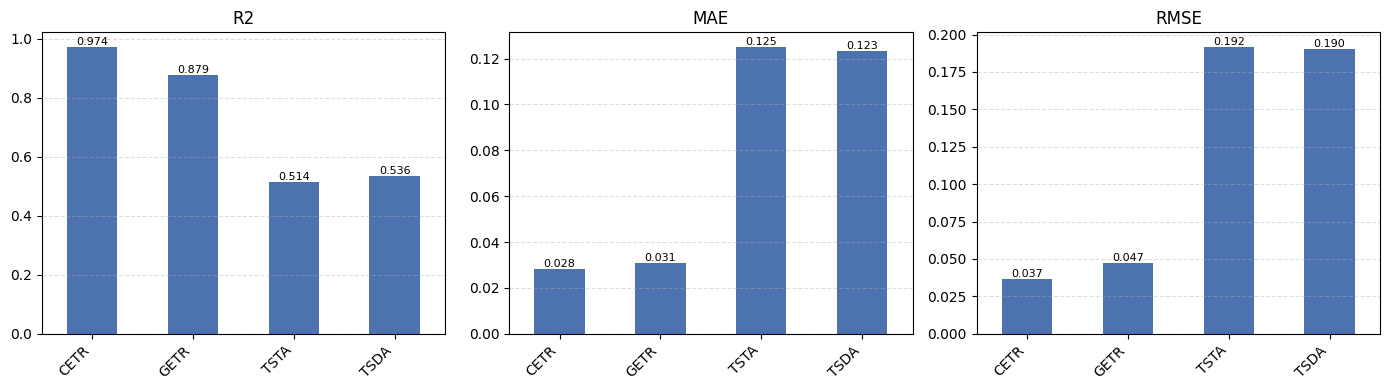

In [9]:
# 11. 시각화 (Per-target 성능 막대 그래프)
import matplotlib.pyplot as plt

# 타겟별 성능지표 계산
metrics = {'R2': [], 'MAE': [], 'RMSE': []}
for i, col in enumerate(target_columns):
    y_true = y_test_seen[col]
    y_pred = pred_seen[:, i]
    metrics['R2'].append(r2_score(y_true, y_pred))
    metrics['MAE'].append(mean_absolute_error(y_true, y_pred))
    metrics['RMSE'].append(root_mean_squared_error(y_true, y_pred))

metrics_df = pd.DataFrame(metrics, index=target_columns)
print(metrics_df)

# 시각화
fig, axes = plt.subplots(1, 3, figsize=(14, 4))
for ax, metric in zip(axes, metrics_df.columns):
    metrics_df[metric].plot(kind='bar', ax=ax, color='#4C72B0')
    ax.set_title(metric)
    ax.set_xticklabels(metrics_df.index, rotation=45, ha='right')
    ax.grid(axis='y', linestyle='--', alpha=0.4)
    for p in ax.patches:
        val = p.get_height()
        ax.annotate(f'{val:.3f}', (p.get_x() + p.get_width()/2, val),
                    ha='center', va='bottom', fontsize=8, rotation=0)
plt.tight_layout()
plt.show()

In [10]:
# 12. 결과 저장 (Seen test)
import numpy as np, pandas as pd
pred_df = pd.DataFrame(
    data = pred_seen,
    columns = [f'pred_{col}' for col in y_test_seen.columns],
    index = y_test_seen.index
)
actual_df = y_test_seen.add_prefix('actual_')
results_df = pd.concat([actual_df, pred_df], axis=1)
results_df.to_csv('rf_actual_vs_predicted_seen_2024.csv', index=True)
print('Saved: rf_actual_vs_predicted_seen_2024.csv')

# Per-target metrics 저장
metric_rows = []
for i, col in enumerate(target_columns):
    metric_rows.append({
        'target': col,
        'R2': r2_score(y_test_seen[col], pred_seen[:, i]),
        'MAE': mean_absolute_error(y_test_seen[col], pred_seen[:, i]),
        'RMSE': root_mean_squared_error(y_test_seen[col], pred_seen[:, i])
    })
metrics_df = pd.DataFrame(metric_rows)
metrics_df.to_csv('rf_metrics_seen_2024.csv', index=False)
print('Saved: rf_metrics_seen_2024.csv')

Saved: rf_actual_vs_predicted_seen_2024.csv
Saved: rf_metrics_seen_2024.csv


## Reference site
    지표 및 점수
    https://scikit-learn.org/stable/modules/model_evaluation.html#model-evaluation
    https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics
